# Libraries

In [31]:
# General
import pandas as pd
import numpy as np

# Data Management
from dataclasses import dataclass, field
from collections import namedtuple
from typing import List, Any

# Solar Position to Time of Day Calculation
from pvlib import solarposition
from scipy.optimize import minimize_scalar

# Graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Time Handling. Also so that pandas .dt.time series plays nice with matploblib.
from datetime import datetime, date, time

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data Import

## Functions

In [103]:
# Convert timestamps to datetimes
def convert_unixtime(df, column, format = None, unit = None, new_name = "datetime"):
    df[new_name] = pd.to_datetime(df[column], format = format, unit = unit)

# Clean data
def cleaner(df, variable_name):
    df[variable_name] = df[variable_name].replace([-9999.0], np.nan) # Replace visible/known missing values
    df = df.reindex(pd.date_range(start = df.index[0], end = df.index[-1], freq = "30min")) # Reindex to deal with hidden missing values
    #df.index.name = "date" # put the name of the index column back!
    df = df[[variable_name]].copy() # Select Variables
    return df

def calc_time_by_solar(latitude, longitude, date, target_elevation, target_azimuth):

    # Minimize the difference in solar position
    def objective(mins_since_midnight):
        dt = date + pd.Timedelta(minutes = mins_since_midnight)
        pos = solarposition.get_solarposition(dt, latitude, longitude)
        elev = pos['apparent_elevation'].values[0]
        azim = pos['azimuth'].values[0]
        return (elev - target_elevation)**2 + (azim - target_azimuth)**2
    
    # Optimize over a 24-hour period
    res = minimize_scalar(objective, bounds = (0, 1440), method = 'bounded') # using 1440 for number of mins in 24 hours. Don't need more resolution than this
    recovered_datetime = date + pd.Timedelta(minutes = res.x) # Get the time of day (res.x) and add it to the input date.
    
    return recovered_datetime

def normalise_azimuth(df, column):
    for idx, azimuth in enumerate(df[column]):
        # If azimuth is less than 0, add 360 to make it in the 0 to 360 range.
        if azimuth < 0:
            df.at[idx, column] = azimuth + 360

## Data

Declare my dataclass to contain my data. We create a dataclass (simplifed way to make a class). It means we can build a custom data structure to hold all our data sources. Neat and tidy.

In [104]:
coordinates = namedtuple("coordinates", ["lat", "lon"])

@dataclass
class class_data:
    name: str
    flux: pd.DataFrame
    satellite: pd.DataFrame
    paired: pd.DataFrame
    fusion: pd.DataFrame
    stats: dict
    coords: coordinates
    units: dict
    longnames: dict

Construct and populate class_data fields and import data

In [105]:
data = {
    "se_sto": class_data(
        name = "Abisko-Stordalen Palsa Bog",
        flux = pd.read_csv(
            "../data/flux/abisko-stordalen-palsa-bog/ICOSETC_SE-Sto_FLUXNET_HH_L2.csv", 
            usecols = [
                "TIMESTAMP_END",
                "GPP_DT_VUT_REF", # gross primary production
                "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
                "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
                #"SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
                #"SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
                #"SWC_F_MDS_5", # soil water content at depth 5, gap-filled with MDS
                #"SWC_F_MDS_6" # soil water content at depth 6, gap-filled with MDS
            ]
        ),
        satellite = pd.read_csv("../data/satellite/tundra-flux_data_nosnowmask.csv"),
        paired = pd.DataFrame(),
        fusion = pd.DataFrame(),
        stats = {},
        coords = coordinates(68.35594288, 19.04520892),
        units = {
            "unix": "Unix",
            "gpp": "µmol",
            "swc": "%"
        },
        longnames = {
            "gpp": "Gross Primary Production",
            "swc": "Soil Water Content"
        }
    ),
    #"fi_ken": class_data(
    #    name = "Kenttärova",
    #    flux = pd.read_csv(
    #        "../data/flux/kenttarova/ICOSETC_FI-Ken_FLUXNET_HH_L2.csv",
    #        usecols = [
    #            "TIMESTAMP_END",
    #            "GPP_DT_VUT_REF", # gross primary production
    #            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
    #            "SWC_F_MDS_2" # soil water content at depth 2, gap-filled with MDS
    #        ]
    #    ),
    #    satellite = pd.DataFrame(),
    #    paired = pd.DataFrame(),
    #    stats = {},
    #    coords = coordinates(67.98721, 24.24301),
    #    units = {
    #        "unix": "Unix",
    #        "GPP": "µmol",
    #        "SWC": "%"
    #    },
    #    longnames = {
    #        "gpp": "Gross Primary Production",
    #        "swc": "Soil Water Content"
    #    }
    #),
    #"fi_sod": class_data(
    #    name = "Sodankylä",
    #    flux = pd.read_csv(
    #        "../data/flux/sodankyla/ICOSETC_FI-Sod_FLUXNET_HH_L2.csv",
    #        usecols = [
    #            "TIMESTAMP_END",
    #            "GPP_DT_VUT_REF", # gross primary production
    #            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
    #            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
    #            #"SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
    #            #"SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
    #            #"SWC_F_MDS_5" # soil water content at depth 5, gap-filled with MDS
    #        ]
    #    ),
    #    satellite = pd.DataFrame(),
    #    paired = pd.DataFrame(),
    #    stats = {},
    #    coords = coordinates(67.36239, 26.63859),
    #    units = {
    #        "unix": "Unix",
    #        "GPP": "µmol",
    #        "SWC": "%"
    #    },
    #    longnames = {
    #        "gpp": "Gross Primary Production",
    #        "swc": "Soil Water Content"
    #    }
    #),
    #"fi_var": class_data(
    #    name = "Varrio",
    #    flux = pd.read_csv(
    #        "../data/flux/varrio/ICOSETC_FI-Var_FLUXNET_HH_L2.csv",
    #        usecols = [
    #            "TIMESTAMP_END",
    #            "GPP_DT_VUT_REF", # gross primary production
    #            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
    #            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
    #        ]
    #    ),
    #    satellite = pd.DataFrame(),
    #    paired = pd.DataFrame(),
    #    stats = {},
    #    coords = coordinates(67.7549, 29.61),
    #    units = {
    #        "unix": "ms",
    #        "GPP": "µmol",
    #        "SWC": "%"
    #    },
    #    longnames = {
    #        "gpp": "Gross Primary Production",
    #        "swc1": "Soil Water Content 4cm"
    #        "swc2": "Soil Water Content 8cm"
    #    }
    #)
}

## Pre-processing

Pre-process flux data

In [106]:
for key, item in data.items():
    
    df = item.flux
    
    # Rename Columns
    df = df.rename(columns = {
    "TIMESTAMP_END": "unixtime",
    "GPP_DT_VUT_REF": "gpp",
    "SWC_F_MDS_1": "swc1",
    "SWC_F_MDS_2": "swc2"
    })
    
    # Convert times
    convert_unixtime(df, "unixtime", "%Y%m%d%H%M")
    df = df.set_index("datetime", drop = False) # Make the new datetime column the index
    df["time_of_day"] = [datetime.combine(date.today(), t) for t in df["datetime"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    df["day_of_year"] = df["datetime"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    
    # Sort
    df.sort_index(inplace = True)
    
    # Clean
    df = pd.concat([cleaner(df[[column]].copy(), column) for column in df.columns], axis = 1) # Clean and reassign dataframe
    
    data[key].flux = df

Pre-process satellite data

In [107]:
for key, item in data.items():
    
    df = item.satellite
    
    # Rename columns
    df.rename(
        columns = {
            "time": "unixtime",
            "solarElevation": "solar_elevation",
            "solarAzimuth": "solar_azimuth",
            "platformID": "platform_id",
            "Red": "red",
            "NIR": "nir",
            "SWIR_1": "swir",
        },
        inplace = True
    )
    
    # Convert times
    convert_unixtime(df, "unixtime", unit = "ms")
        
    # Calculate time of day for awkward satellites
    normalise_azimuth(df, "solar_azimuth")
    mask = df["platform_id"].isin(["MOD09GA", "MYD09GA", "VNP09GA"]) # Filter the dataframe to satellites without time of day
    masked_df = df.loc[mask] # Filter our df to the platform_id mask
    #masked_df["datetime"] = masked_df["datetime"].dt.normalize() # Get the datetime ensure that time is removed (AKA set time to midnight). It should already be midnight but we do it just in case
    masked_df.loc[:, "datetime"] = masked_df["datetime"].dt.normalize()
    for idx, row in masked_df.iterrows():
        recovered_datetime = calc_time_by_solar(
            latitude = data[key].coords.lat,
            longitude = data[key].coords.lon,
            date = row["datetime"],
            target_elevation = row["solar_elevation"],
            target_azimuth = row["solar_azimuth"]
            )
        df.loc[idx, "datetime"] = recovered_datetime
    
    df = df.set_index("datetime", drop = False) # Set datetime to index
    df.rename_axis(None, inplace = True) # Remove the index column header (otherwise using .merge won"t work when creating the paired dataset)
    df["time_of_day"] = [datetime.combine(date.today(), t) for t in df["datetime"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    df["day_of_year"] = df["datetime"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    
    #df["unixtime"] = df["time_of_day"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    df["unixtime"] = df["datetime"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    
    # Sort
    df.sort_index(inplace = True)
    
    # TEMPORARY - Satellite Filter
    #df = df[df["platform_id"] != "LT04"]
    #df = df[df["platform_id"] != "LT05"]
    #df = df[dataframe["platform_id"] != "LE07"]
    #df = df[dataframe["platform_id"] != "LC08"]
    #df = df[dataframe["platform_id"] != "LC09"]
    #df = df[dataframe["platform_id"] != "S2_SR_HARMONIZED"]
    #df = df[dataframe["platform_id"] != "MOD09GA"]
    #df = df[dataframe["platform_id"] != "MYD09GA"]
    df = df[df["platform_id"] != "AST_L1T_003"] # Radiance conversion problem
    #df = df[df["platform_id"] != "AVHRR"]
    df = df[df["platform_id"] != "VNP09GA"] # Has issues, some low GPPe values maybe
    
    # Update units
    item.units["solar_elevation"] = "$^o$"
    item.units["solar_azimuth"] = "$^o$"
    item.units["red"] = "Watts m⁻² sr⁻¹ μm⁻¹"
    item.units["nir"] = "Watts m⁻² sr⁻¹ μm⁻¹"
    item.units["swir"] = "Watts m⁻² sr⁻¹ μm⁻¹"
    
    data[key].satellite = df

# Processing
Now that our data are cleaned and have nice variable names we can process them.

## Harmonisation
Not all bands are created equal. The width of each between satellites varies. This may cause some slight issues when we create our indices and try to analyse the data as if it were one. We can try and adjust for this by harmonising the data with a form of bias correction.

## Indices
Let's create some indices from our band values to identify primary productivity and soil moisture.

In [ ]:
def calculate_indices(df):
    nir = df["nir"]
    red = df["red"]
    swir = df["swir"]
    #green = df.get("green")

    df["ndvi"] = (nir - red) / (nir + red)
    df["msavi"] = (2 * nir + 1 - np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red))) / 2
    df["nirv"] = ((nir - red) / (nir + red) - 0.08) * nir
    df["msi"] = swir / nir
    df["ndwi"] = (nir - swir) / (nir + swir)
    df["gvmi"] = (nir + 0.1 - swir + 0.02) / (nir + 0.1 + swir + 0.02)
    #df["mndwi"] = (green - swir) / (green + swir)
    df["tsi"] = (red - nir) / (red + nir)

    return df

And make sure we clean the normalised difference indices so our dataframe only has row values in these columns between 1 and -1.

In [185]:
def clean_nd_indices(df):
    ndvi = df["ndvi"]
    ndwi = df["ndwi"]
    tsi = df["tsi"]
    
    mask = (ndvi > -1) & (ndvi < 1) & (ndwi > -1) & (ndwi < 1) & (tsi > -1) & (tsi < 1)
    return df[mask]

Let's apply these functions to our satellite data.

In [187]:
for key, item in data.items():
    
    df = item.satellite
    
    df = calculate_indices(df)
    df = clean_nd_indices(df)
    
    data[key].satellite = df
    
    # Update our longnames
    item.longnames["ndvi"] = "Normalised Difference Vegetation Index"
    item.longnames["msavi"] = "Modified Soil Adjusted Vegetation Index"
    item.longnames["nirv"] = "Near Infra-red Reflectance of Vegetation"
    item.longnames["msi"] = "Moisture Stress Index"
    item.longnames["ndwi"] = "Normalised Difference Water Index"
    item.longnames["gvmi"] = "Global Vegetation Moisture Index"
    item.longnames["mndwi"] = "Modified Normalised Difference Water Index"

## Random Forest Regressor
Our satellite indices are a little meaningless. Whilst we know that, for example, NDVI has a strong linear relationship (ish) with gross primary production, it isn't gross primary production. It is a proxy.

Let's fix that by training a random forest regressor model on our data!

This way we can make our satellite record show an estimate of GPP and soil moisture. It's the best of both worlds; *in situ* data and a long-term record.

### Pairing the Data

If we are to find relationships between our satellite and flux data we need to merge the two dataframes. We can do so based on **time**. Our flux data is half-hourly (!) so we just need to find the closest one of these for each of our satellite acquisition times (Hence all that messing about earlier on with datetimes and solar position...).

In [188]:
for key, item in data.items():
    
    df_flux = item.flux.copy()
    df_satellite = item.satellite.copy()
    
    # Clip satellite to flux tower min and max times
    datetime_start = df_flux["datetime"].min()
    datetime_end = df_flux["datetime"].max()
    df_satellite = df_satellite.dropna(subset = ["datetime"])
    df_satellite_subset = df_satellite[(df_satellite["datetime"] >= datetime_start) & (df_satellite["datetime"] <= datetime_end)]
    
    # Merge Satellite and Flux data by nearest datetime column values
    df_paired = pd.merge_asof(
        df_satellite_subset.sort_index(), df_flux.sort_index(), # should be sorted already, but why take the chance!
        left_on = "datetime", right_on = "datetime",
        direction = "nearest",
        suffixes = ("", "_flux") # keep satellite cols without suffix so that when we apply the random forest model we dont have to change col names. Append _flux to duplicate flux cols
    )
    
    data[key].paired = df_paired # Remember, we already defined "paired" as a dataframe in our class, how convenient!

### Train Random Forest Regressor
Using our paired dataset we can now use a random forest decision tree to train a regressor model to quantify the relationship between our satellite data and flux tower gross primary production and soil moisture variables. (*oooh*)

#### Functions

In [189]:
def rf_prep(df, mode, categorical_features, training_features, target_feature = None):
    
    # One-hot Encode Categorical Variables. Just make the platform id column into loads of columns of true or false for each platform id. See training_features variable below.
    df = pd.get_dummies(df, columns = categorical_features, drop_first = False)
    
    # Select relevant features to train on.
    X = df[training_features]

    if mode == "apply":
        return df, X
    
    if mode == "train":
        y = df[target_feature]
        
        # Drop rows where X or y have NaNs
        Xy = pd.concat([X, y], axis = 1).dropna()
        X = Xy[training_features]
        y = Xy[target_feature]
        
        return X, y
    
def rf_train(X, y, set_aside_proportion, training_features, n_estimators = 1000, max_features = 0.4, seed = 2):
    
    # Split into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = set_aside_proportion, random_state = seed)
    
    
    # Train and Fit Random Forest Regressor model
    model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = None,
        min_samples_split = 2, min_samples_leaf = 1,
        max_features = max_features,
        bootstrap = True,
        random_state = seed)
    model.fit(X_train, y_train)
    
    # How good is the model?
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    print("R^2 Score:", r2)
    print("RMSE:", rmse)
    
    # What features were important?
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({"Feature": training_features, "Importance": importances})
    feature_importance.sort_values(by = "Importance", ascending = False, inplace = True)

    feature_importance.plot(kind = "bar", x = "Feature", y = "Importance", legend = False)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "rmse": rmse,
        "training_features": training_features,
        "feature_importance": feature_importance
    }

#### Run

In [190]:
# Reset
data["se_sto"].fusion = pd.DataFrame()

Gross Primary Production

R^2 Score: 0.9316892697378736
RMSE: 0.48785135216548464


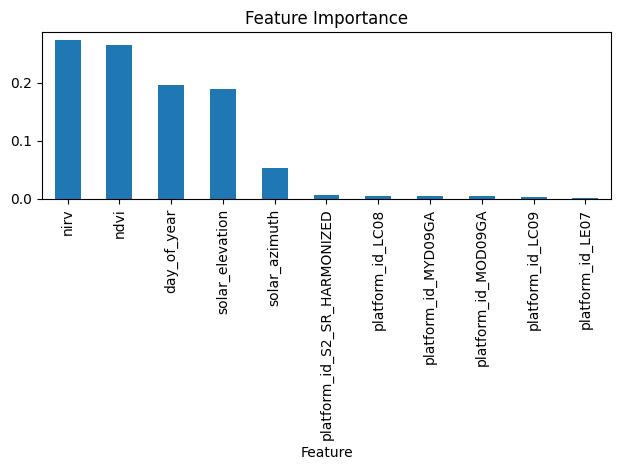

In [227]:
training_features = [
    #"red",
    #"nir",
    #"swir",
    "solar_elevation",
    "solar_azimuth",
    "day_of_year",
    #"unixtime", # We shouldn't include this as it's values will mess with the random forest
    "platform_id_LC08",
    "platform_id_LC09",
    "platform_id_LE07",
    "platform_id_S2_SR_HARMONIZED",
    "platform_id_MOD09GA",
    "platform_id_MYD09GA",
    # "Platform ID_AVHRR",
    "ndvi",
    "nirv",
    #"msavi",
    #"msi",
    #"ndwi",
    #"gvmi",
    #"tsi",
]

for key, item in data.items():
    
    df_paired = item.paired.copy() # copy as we don't want to alter the actual dataframes
    df_satellite = item.satellite.copy()
    
    # Prepare
    X, y = rf_prep(
        df = df_paired,
        mode = "train",
        categorical_features = ["platform_id"],
        training_features = training_features,
        target_feature = "gpp"
        )
        
    # Train
    rf_output = rf_train(
        X = X,
        y = y,
        set_aside_proportion = 0.2,
        training_features = training_features,
        n_estimators = 1000,
        max_features = 0.1,
        seed = 2)

    # Apply Model to our dataset
    df_satellite, X = rf_prep(
        df = df_satellite,
        mode = "apply",
        categorical_features = ["platform_id"],
        training_features = training_features,
        )
    predicted = rf_output["model"].predict(df_satellite[training_features])
    
    # Save to our data_class
    data[key].stats = {
        "rf_output": rf_output
        }
    data[key].fusion["datetime"] = df_satellite["datetime"]
    data[key].fusion["day_of_year"] = df_satellite["day_of_year"]
    data[key].fusion["time_of_day"] = df_satellite["time_of_day"]
    data[key].fusion["gppe"] = predicted
    
    # Update our units and longnames
    item.units["gppe"] = "µmol"
    item.longnames["gppe"] = "Gross Primary Production Estimate"

Soil Water Content

R^2 Score: 0.9052334736493335
RMSE: 9.041168831568173


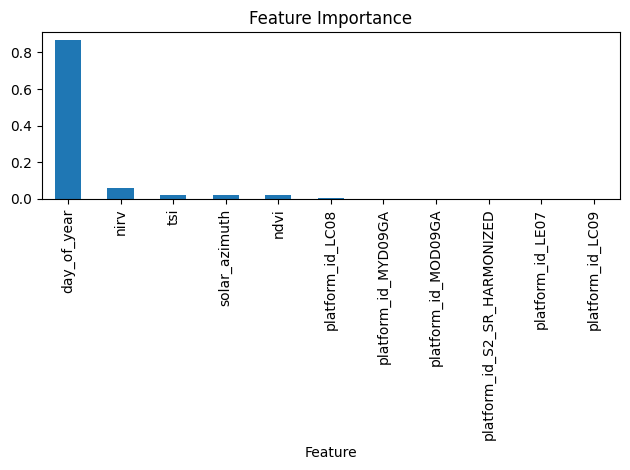

In [225]:
training_features = [
    #"red",
    #"nir",
    #"swir",
    #"solar_elevation",
    "solar_azimuth",
    "day_of_year",
    #"unixtime", # We shouldn't include this as it's values will mess with the random forest
    "platform_id_LC08",
    "platform_id_LC09",
    "platform_id_LE07",
    "platform_id_S2_SR_HARMONIZED",
    "platform_id_MOD09GA",
    "platform_id_MYD09GA",
    ## "Platform ID_AVHRR",
    "ndvi",
    "nirv",
    #"msavi",
    #"msi",
    #"ndwi",
    #"gvmi",
    "tsi",
]


for key, item in data.items():
    
    df_paired = item.paired.copy() # copy as we don't want to alter the actual dataframes
    df_satellite = item.satellite.copy()
    
    # Prepare
    X, y = rf_prep(
        df = df_paired,
        mode = "train",
        categorical_features = ["platform_id"],
        training_features = training_features,
        target_feature = "swc2"
        )
        
    # Train
    rf_output = rf_train(
        X = X,
        y = y,
        set_aside_proportion = 0.2,
        training_features = training_features,
        n_estimators = 1000,
        max_features = 0.9,
        seed = 2)

    # Apply Model to our dataset
    df_satellite, X = rf_prep(
        df = df_satellite,
        mode = "apply",
        categorical_features = ["platform_id"],
        training_features = training_features,
        )
    predicted = rf_output["model"].predict(df_satellite[training_features])
    
    # Save to our data_class
    data[key].stats = {
        "rf_output": rf_output
        }
    #data[key].fusion["datetime"] = df_satellite["datetime"]
    #data[key].fusion["day_of_year"] = df_satellite["day_of_year"]
    #data[key].fusion["time_of_day"] = df_satellite["time_of_day"]
    data[key].fusion["swce"] = predicted
    
    # Update our units and longnames
    item.units["gppe"] = "µmol"
    item.longnames["gppe"] = "Gross Primary Production Estimate"

In [82]:
data["se_sto"].fusion

,datetime,day_of_year,time_of_day,gppe,swce
1981-09-15 13:15:00.000,1981-09-15 13:15:00.000,258,2025-05-10 13:15:00.000,1.742705,5.926000
1984-05-09 09:56:29.675,1984-05-09 09:56:29.675,130,2025-05-10 09:56:29.675,0.332289,29.902832
1984-05-25 09:56:58.138,1984-05-25 09:56:58.138,146,2025-05-10 09:56:58.138,1.160760,20.075610
1984-05-27 09:44:39.425,1984-05-27 09:44:39.425,148,2025-05-10 09:44:39.425,1.366809,20.286630
1984-06-03 09:50:59.417,1984-06-03 09:50:59.417,155,2025-05-10 09:50:59.417,2.575950,14.430806
...,...,...,...,...,...
2025-04-13 10:42:00.407,2025-04-13 10:42:00.407,103,2025-05-10 10:42:00.407,0.068160,3.082800
2025-04-13 10:42:04.245,2025-04-13 10:42:04.245,103,2025-05-10 10:42:04.245,0.063555,3.084040
2025-04-21 10:42:08.774,2025-04-21 10:42:08.774,111,2025-05-10 10:42:08.774,0.159264,2.884340
2025-05-06 10:41:49.113,2025-05-06 10:41:49.113,126,2025-05-10 10:41:49.113,0.299524,28.856974


# Preview Data

## Aesthetics

For making nice graphs. Simple as.

In [83]:
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything"s size easily
fig_gold = 1.618

aes = {
    "gpp": "limegreen"
}

## Functions

In [84]:
def subplots(nrows, ncols, squish_factor, sharex):

    fig, ax = plt.subplots(
        nrows = nrows, ncols = ncols, 
        figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
        sharex = sharex, constrained_layout = True
    )
    ax = ax.flatten()
    
    return fig, ax

def scatter(ax, df, x_var, y_var, data_class):
    
    ax.scatter(
        x = df[x_var], y = df[y_var],
        c = aes[y_var], s = 10, alpha = 0.1, edgecolors = None
    )
    ax.set_title(f"a) {data_class.name}", loc = "left")
    

## Raw Data

Flux GPP

Text(0.5, 0, 'Time of Day')

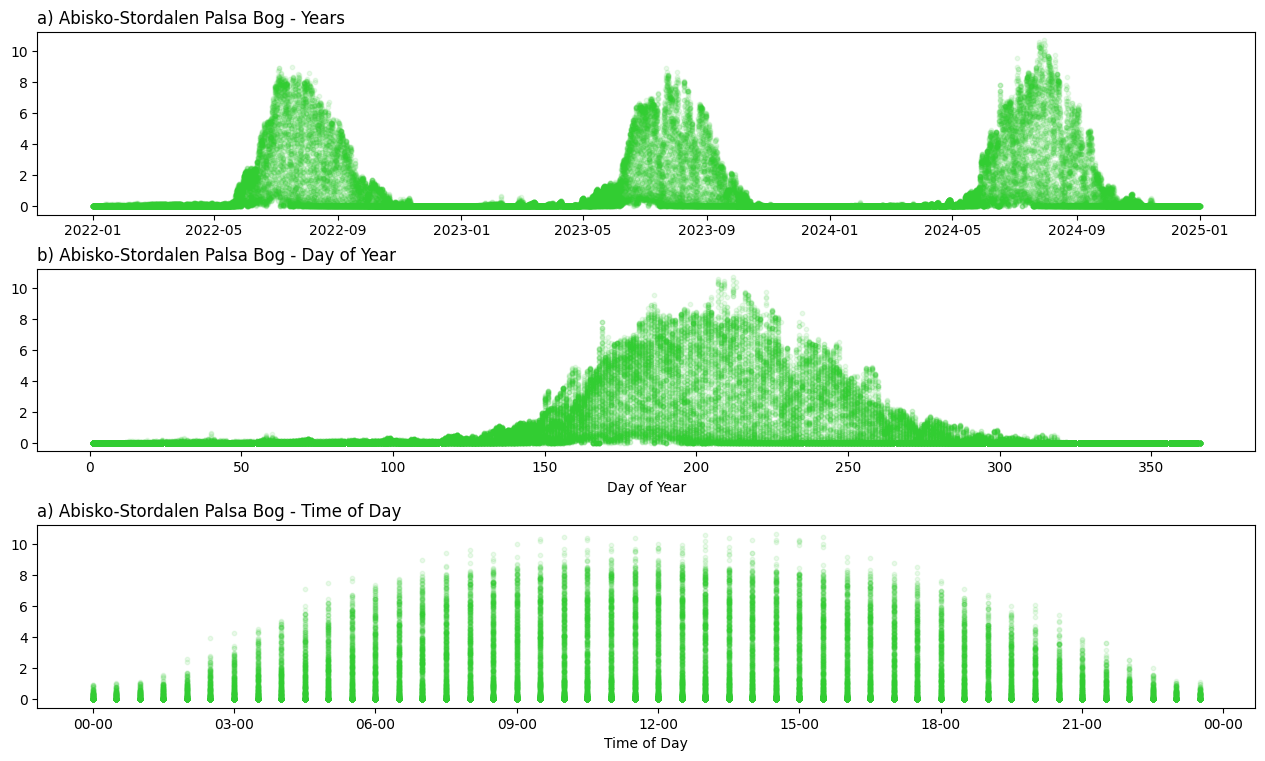

In [85]:
df = data["se_sto"].flux

nrows = 3
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = df["datetime"], y = df["gpp"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Years", loc = "left")

ax[1].scatter(
    x = df["day_of_year"], y = df["gpp"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")
ax[1].set_xlabel("Day of Year")

ax[2].scatter(
    x = df["time_of_day"], y = df["gpp"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("a) Abisko-Stordalen Palsa Bog - Time of Day", loc = "left")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[2].set_xlabel("Time of Day")

Flux SWC

Text(0.5, 0, 'Time of Day')

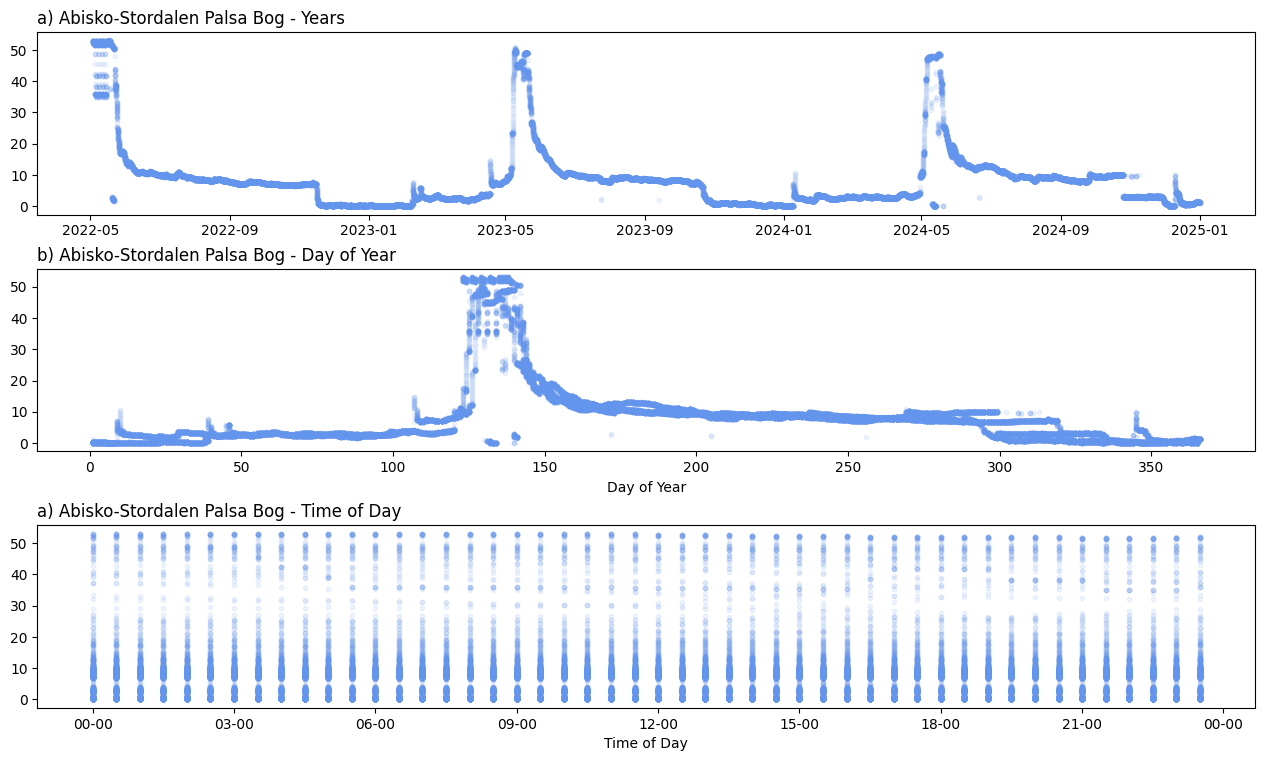

In [86]:
df = data["se_sto"].flux

nrows = 3
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = df["datetime"], y = df["swc2"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Years", loc = "left")

ax[1].scatter(
    x = df["day_of_year"], y = df["swc2"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")
ax[1].set_xlabel("Day of Year")

ax[2].scatter(
    x = df["time_of_day"], y = df["swc2"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("a) Abisko-Stordalen Palsa Bog - Time of Day", loc = "left")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[2].set_xlabel("Time of Day")

Satellite Vegetation Index

Text(0.02, 0.5, 'NDVI')

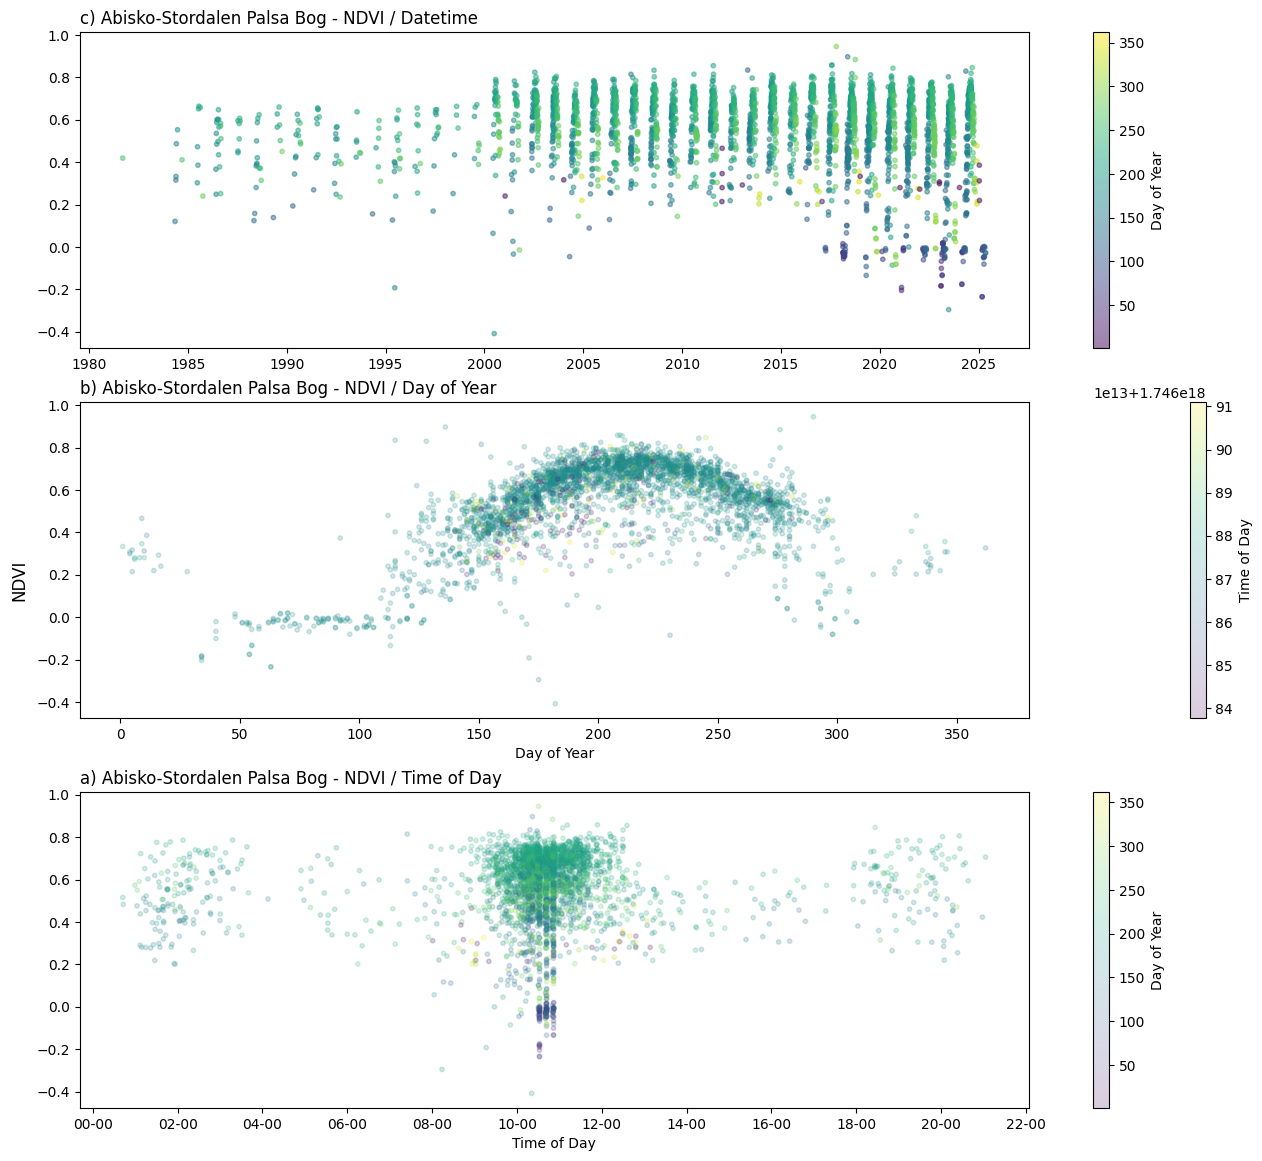

In [87]:
df = data["se_sto"].satellite

nrows = 3
ncols = 1
squish_factor = 4
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp2 = ax[0].scatter(
    x = df["datetime"], y = df["ndvi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_title("c) Abisko-Stordalen Palsa Bog - NDVI / Datetime", loc = "left")
fig.colorbar(sp2, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["day_of_year"], y = df["ndvi"],
    c = df["time_of_day"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - NDVI / Day of Year", loc = "left")
ax[1].set_xlabel("Day of Year")
fig.colorbar(sp1, ax = ax[1], label = "Time of Day")

sp0 = ax[2].scatter(
    x = df["time_of_day"], y = df["ndvi"],
    c = df["day_of_year"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[2].set_xlabel("Time of Day")
ax[2].set_title("a) Abisko-Stordalen Palsa Bog - NDVI / Time of Day", loc = "left")
fig.colorbar(sp0, ax = ax[2], label = "Day of Year")

fig.supylabel("NDVI")

Satellite Soil Moisture Index

Text(0.02, 0.5, 'MSI')

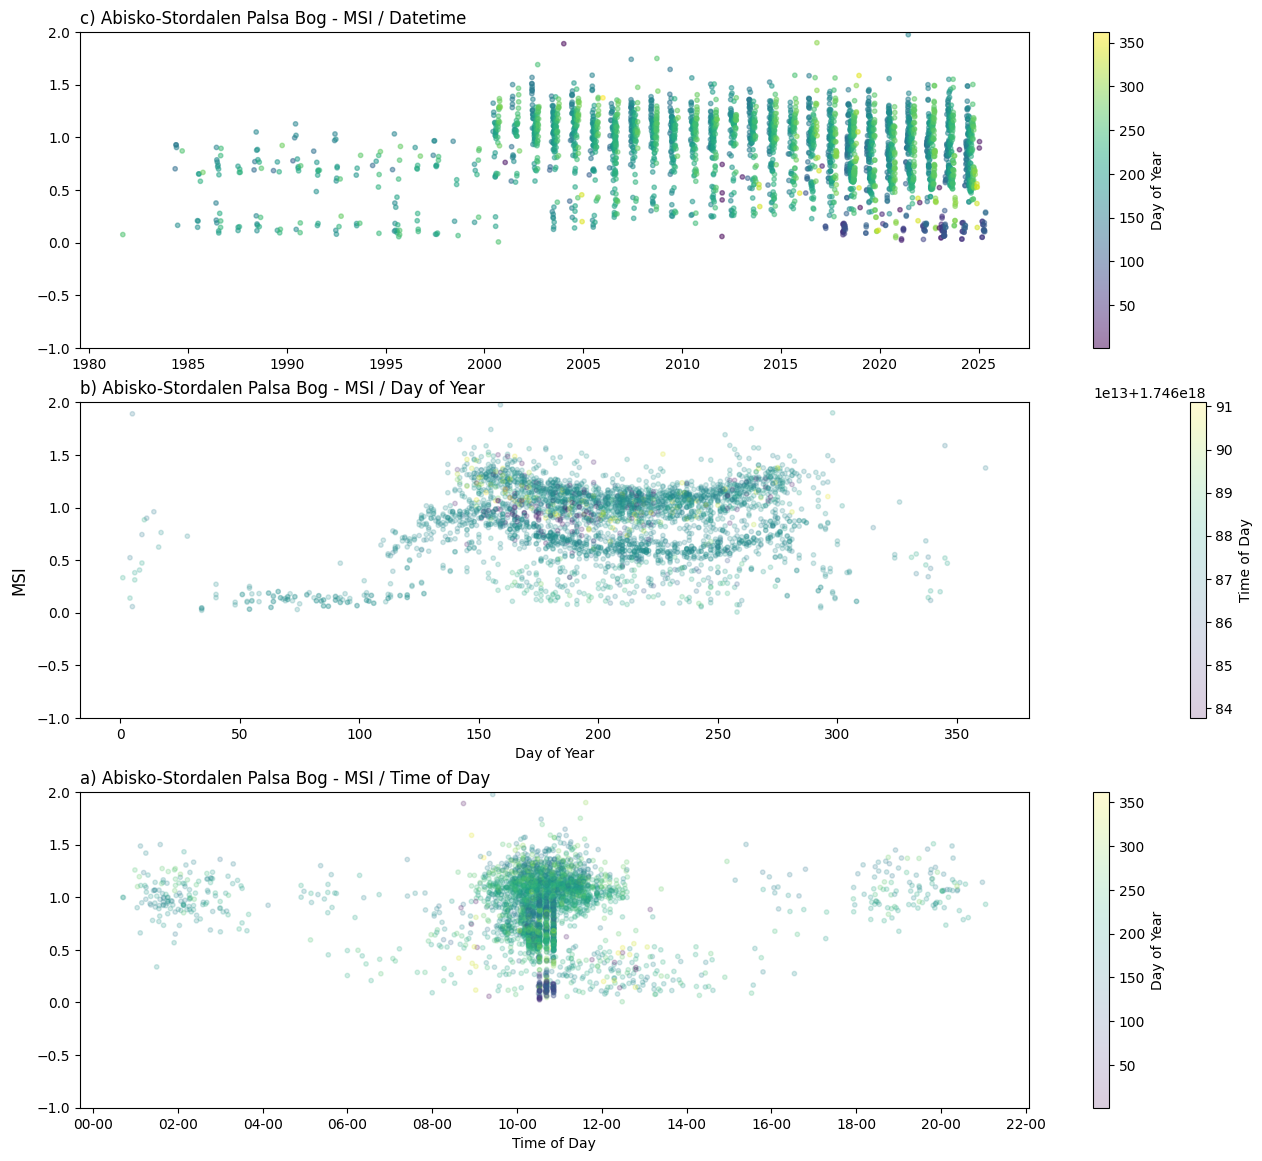

In [88]:
df = data["se_sto"].satellite

nrows = 3
ncols = 1
squish_factor = 4
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp2 = ax[0].scatter(
    x = df["datetime"], y = df["msi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_title("c) Abisko-Stordalen Palsa Bog - MSI / Datetime", loc = "left")
fig.colorbar(sp2, ax = ax[0], label = "Day of Year")
ax[0].set_ylim(-1, 2)

sp1 = ax[1].scatter(
    x = df["day_of_year"], y = df["msi"],
    c = df["time_of_day"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - MSI / Day of Year", loc = "left")
ax[1].set_xlabel("Day of Year")
fig.colorbar(sp1, ax = ax[1], label = "Time of Day")
ax[1].set_ylim(-1, 2)

sp0 = ax[2].scatter(
    x = df["time_of_day"], y = df["msi"],
    c = df["day_of_year"], s = 10, alpha = 0.2, edgecolors = None,
)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[2].set_xlabel("Time of Day")
ax[2].set_title("a) Abisko-Stordalen Palsa Bog - MSI / Time of Day", loc = "left")
fig.colorbar(sp0, ax = ax[2], label = "Day of Year")
ax[2].set_ylim(-1, 2)

fig.supylabel("MSI")

## Paired

Vegetation Indices / GPP

Text(0, 0.5, 'MSAVI')

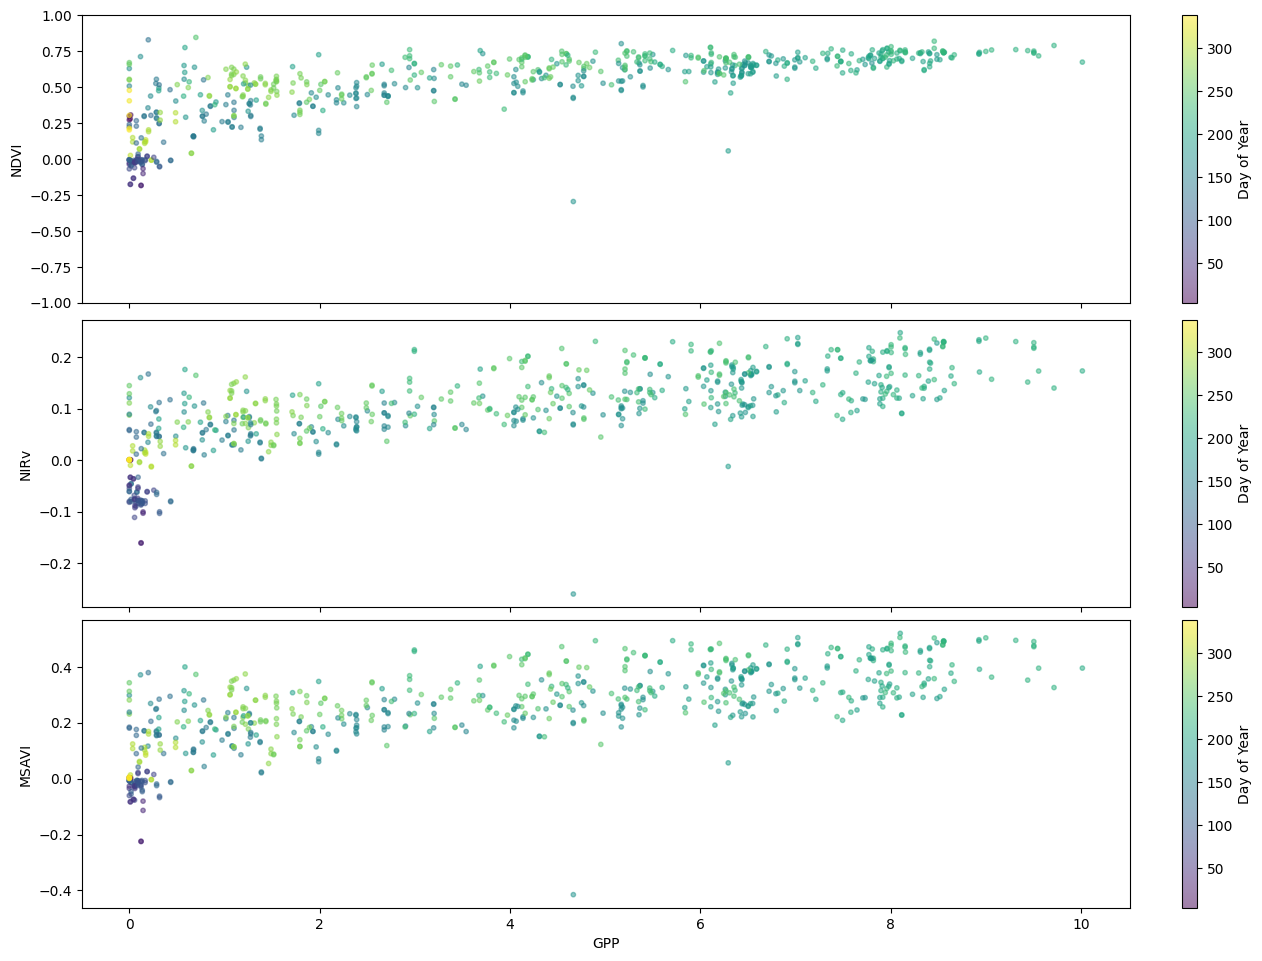

In [89]:
df = data["se_sto"].paired

nrows = 3
ncols = 1
squish_factor = 6
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["gpp"], y = df["ndvi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_ylim(-1, 1)
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")
ax[0].set_ylabel("NDVI")

sp1 = ax[1].scatter(
    x = df["gpp"], y = df["nirv"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
fig.colorbar(sp1, ax = ax[1], label = "Day of Year")
ax[1].set_ylabel("NIRv")

sp2 = ax[2].scatter(
    x = df["gpp"], y = df["msavi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
fig.colorbar(sp1, ax = ax[2], label = "Day of Year")
ax[2].set_xlabel("GPP")
ax[2].set_ylabel("MSAVI")

Water Indices / SWC

Text(0, 0.5, 'GVMI')

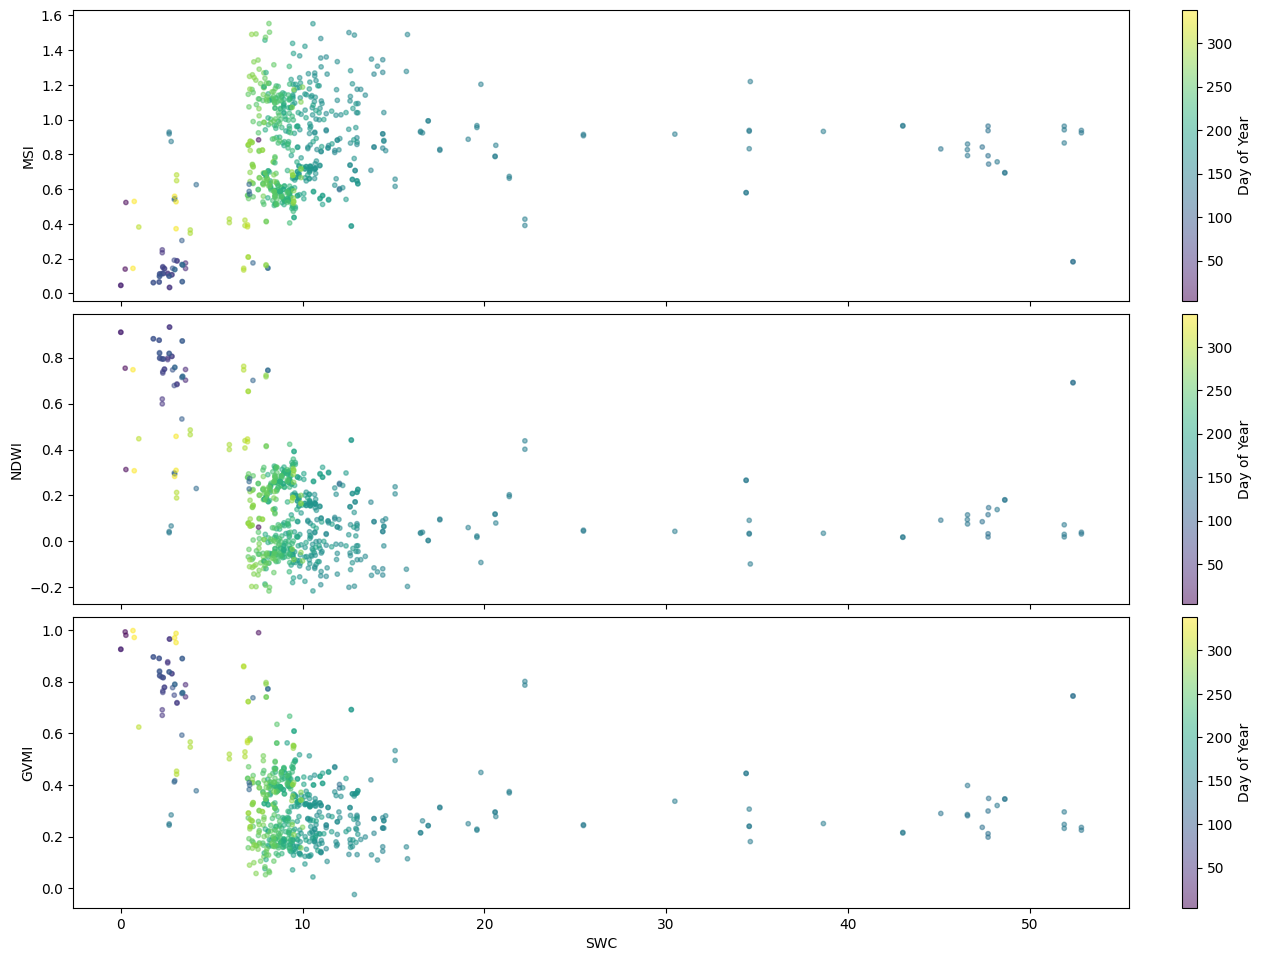

In [90]:
df = data["se_sto"].paired

nrows = 3
ncols = 1
squish_factor = 6
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["swc2"], y = df["msi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")
ax[0].set_ylabel("MSI")

sp1 = ax[1].scatter(
    x = df["swc2"], y = df["ndwi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
fig.colorbar(sp1, ax = ax[1], label = "Day of Year")
ax[1].set_ylabel("NDWI")

sp2 = ax[2].scatter(
    x = df["swc2"], y = df["gvmi"],
    c = df["day_of_year"], s = 10, alpha = 0.5, edgecolors = None,
)
fig.colorbar(sp2, ax = ax[2], label = "Day of Year")
ax[2].set_xlabel("SWC")
ax[2].set_ylabel("GVMI")

## Flux-trained Estimates

GPPe

Text(0.02, 0.5, 'GPPe (µmol)')

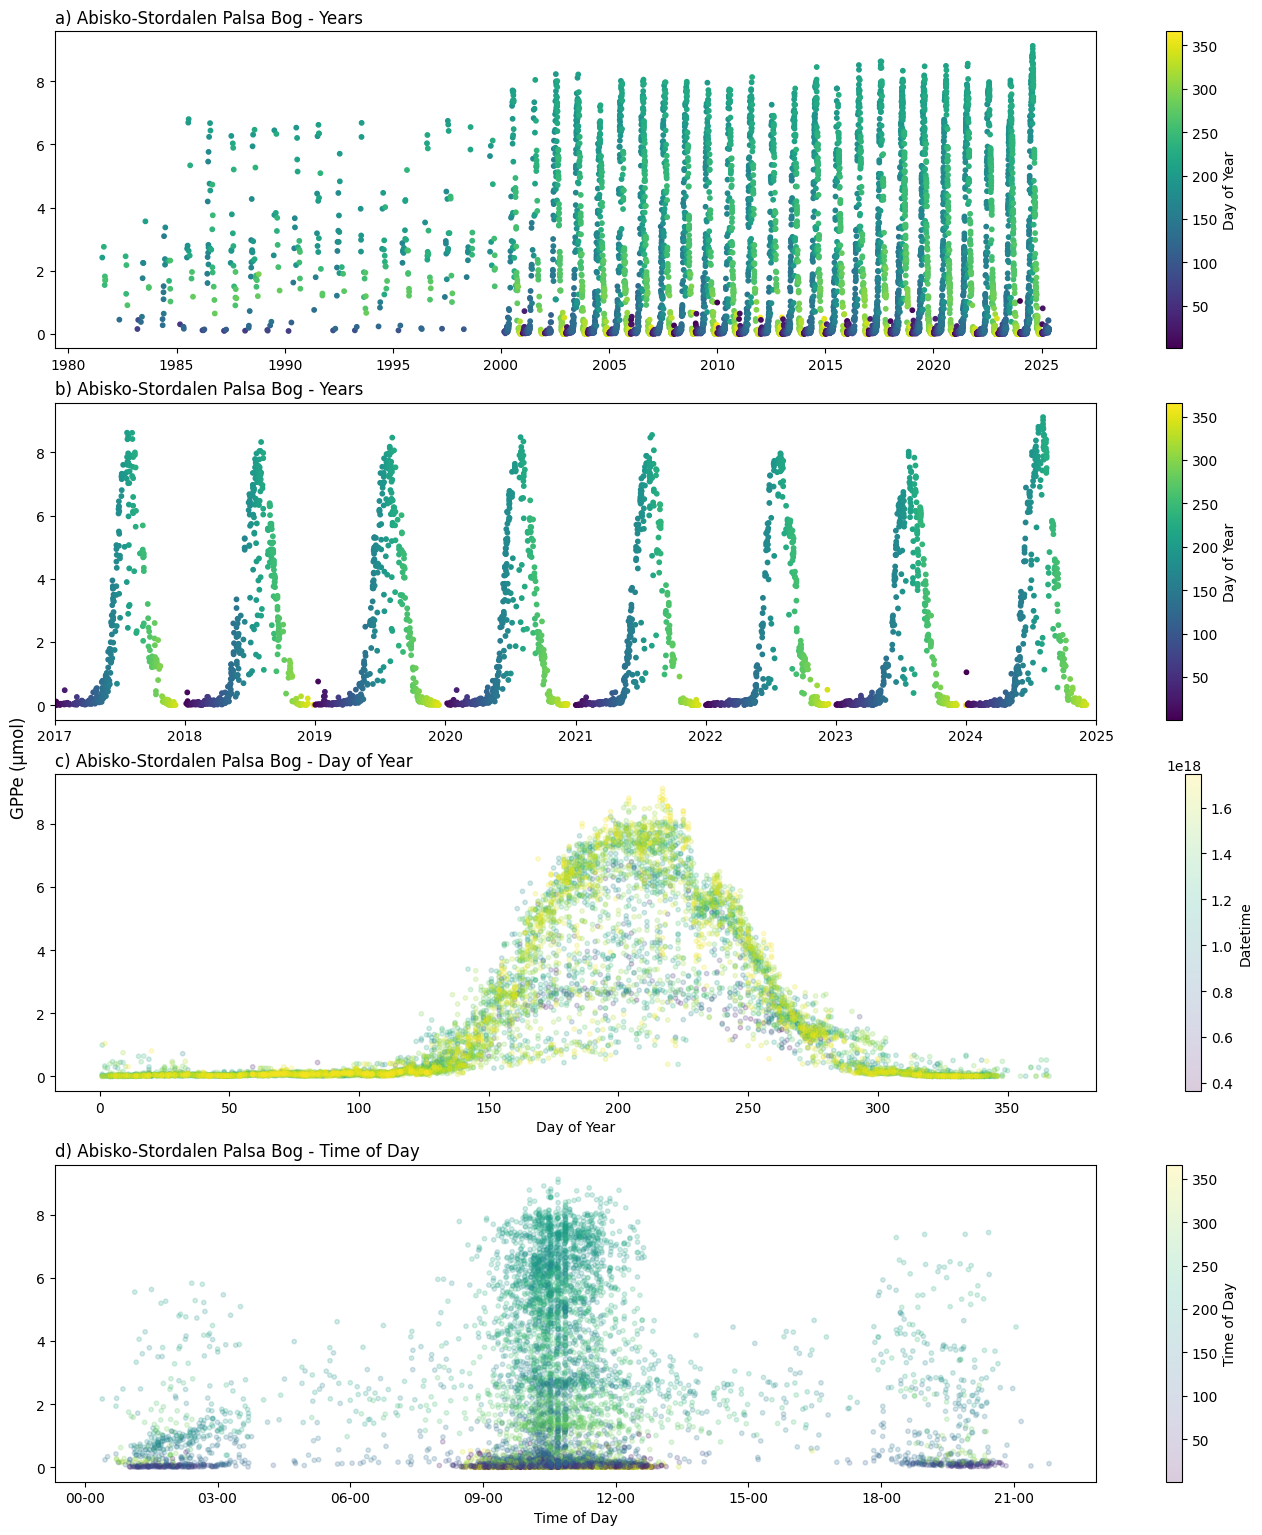

In [218]:
df = data["se_sto"].fusion

nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["datetime"], y = df["gppe"],
    c = df["day_of_year"], s = 10, alpha = 1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Years", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["datetime"], y = df["gppe"],
    c = df["day_of_year"], s = 10, alpha = 1, edgecolors = None
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Years", loc = "left")
fig.colorbar(sp1, ax = ax[1], label = "Day of Year")
ax[1].set_xlim(pd.Timestamp("2017-01-01"), pd.Timestamp("2025-01-01"))

sp2 = ax[2].scatter(
    x = df["day_of_year"], y = df["gppe"],
    c = df["datetime"], s = 10, alpha = 0.2, edgecolors = None
)
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")
ax[2].set_xlabel("Day of Year")
fig.colorbar(sp2, ax = ax[2], label = "Datetime")

sp3 = ax[3].scatter(
    x = df["time_of_day"], y = df["gppe"],
    c = df["day_of_year"], s = 10, alpha = 0.2, edgecolors = None
)
ax[3].set_title("d) Abisko-Stordalen Palsa Bog - Time of Day", loc = "left")
ax[3].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[3].set_xlabel("Time of Day")
fig.colorbar(sp3, ax = ax[3], label = "Time of Day")

fig.supylabel("GPPe (µmol)")

SWCe

Text(0.02, 0.5, 'SWCe (%)')

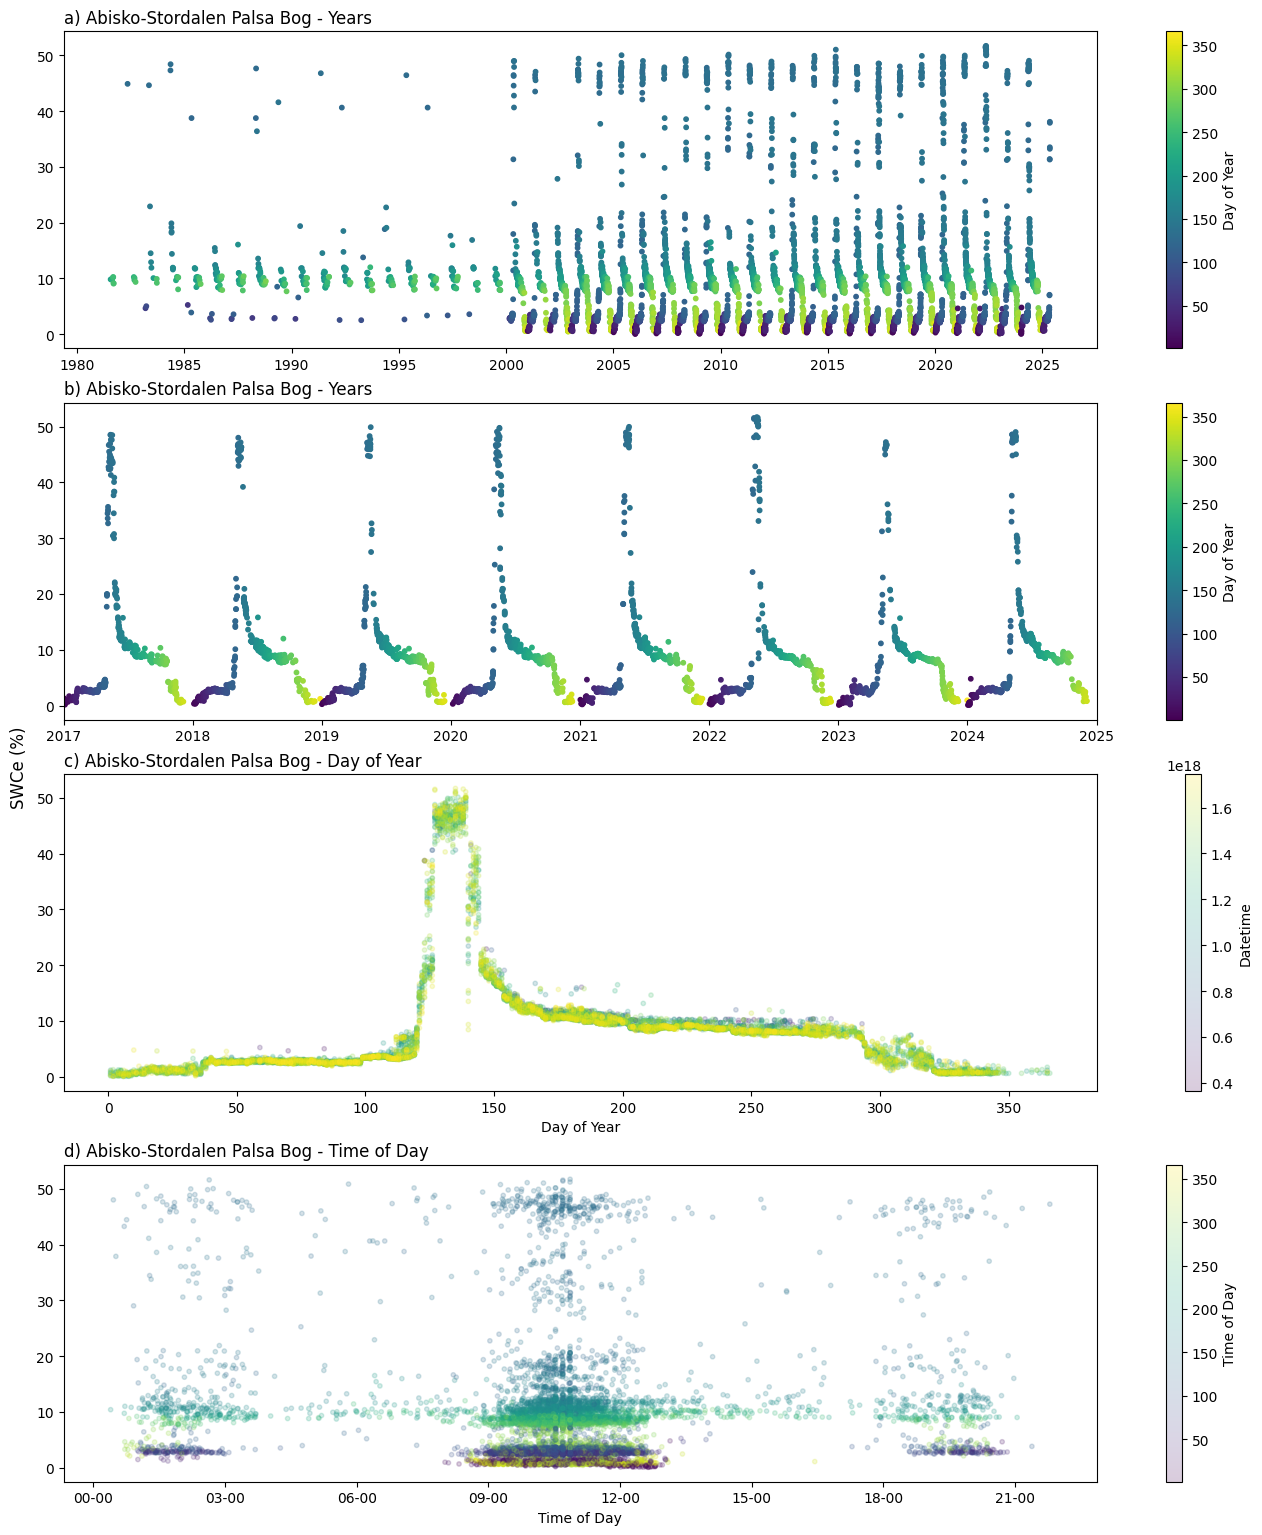

In [223]:
df = data["se_sto"].fusion

nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["datetime"], y = df["swce"],
    c = df["day_of_year"], s = 10, alpha = 1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Years", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["datetime"], y = df["swce"],
    c = df["day_of_year"], s = 10, alpha = 1, edgecolors = None
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Years", loc = "left")
fig.colorbar(sp1, ax = ax[1], label = "Day of Year")
ax[1].set_xlim(pd.Timestamp("2017-01-01"), pd.Timestamp("2025-01-01"))

sp2 = ax[2].scatter(
    x = df["day_of_year"], y = df["swce"],
    c = df["datetime"], s = 10, alpha = 0.2, edgecolors = None
)
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")
ax[2].set_xlabel("Day of Year")
fig.colorbar(sp2, ax = ax[2], label = "Datetime")

sp3 = ax[3].scatter(
    x = df["time_of_day"], y = df["swce"],
    c = df["day_of_year"], s = 10, alpha = 0.2, edgecolors = None
)
ax[3].set_title("d) Abisko-Stordalen Palsa Bog - Time of Day", loc = "left")
ax[3].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
ax[3].set_xlabel("Time of Day")
fig.colorbar(sp3, ax = ax[3], label = "Time of Day")

fig.supylabel("SWCe (%)")